# Big Data - TP #3

Integrantes: Ronny M. Condor, Diego Fasan y María Camila Riancho

El objetivo de este TP es hacer clasificación y regularización aplicada a la EPH.

In [2]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import statsmodels.api as sm     

from sklearn import datasets
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, recall_score 
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import average_precision_score
from sklearn.metrics import RocCurveDisplay
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

from ISLP import load_data



## Parte I: Análisis de la base de hogares y cálculo de pobreza

In [3]:
#2) Abrimos el archivo y vemos las primeras cinco filas
eph_hogar = pd.read_excel("../datasets/usu_hogar_T123.xlsx")
eph_hogar.head(5)

,CODUSU,ANO4,TRIMESTRE,NRO_HOGAR,REALIZADA,REGION,MAS_500,AGLOMERADO,PONDERA,IV1,...,GDECCFR,PDECCFR,ADECCFR,PONDIH,VII1_1,VII1_2,VII2_1,VII2_2,VII2_3,VII2_4
0,TQRMNOPSRHJMKNCDEHLEH00797939,2023,1,1,1,40,N,25,111,2,...,NaN,3.0,3,124,1,2,98,0,0,0
1,TQRMNORQYHLMKPCDEHLEH00717341,2023,1,1,1,40,N,25,150,1,...,NaN,5.0,7,193,2,0,98,0,0,0
2,TQRMNOPUWHLLKSCDEHLEH00798181,2023,1,1,1,40,N,25,156,2,...,NaN,5.0,6,185,1,0,98,0,0,0
3,TQRMNOSSWHKOKRCDEGOIH00778157,2023,1,1,1,40,N,18,229,1,...,NaN,2.0,2,228,2,0,1,0,0,0
4,TQRMNORPUHJMKSCDEGOIH00794685,2023,1,1,1,40,N,18,182,1,...,NaN,5.0,6,194,1,0,97,0,0,0


In [4]:
#Resumen de la base de datos
eph_hogar.info(verbose = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16815 entries, 0 to 16814
Data columns (total 88 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   CODUSU      16815 non-null  object 
 1   ANO4        16815 non-null  int64  
 2   TRIMESTRE   16815 non-null  int64  
 3   NRO_HOGAR   16815 non-null  int64  
 4   REALIZADA   16815 non-null  int64  
 5   REGION      16815 non-null  int64  
 6   MAS_500     16815 non-null  object 
 7   AGLOMERADO  16815 non-null  int64  
 8   PONDERA     16815 non-null  int64  
 9   IV1         16815 non-null  int64  
 10  IV1_ESP     42 non-null     object 
 11  IV2         16815 non-null  int64  
 12  IV3         16815 non-null  int64  
 13  IV3_ESP     22 non-null     object 
 14  IV4         16815 non-null  int64  
 15  IV5         16815 non-null  int64  
 16  IV6         16815 non-null  int64  
 17  IV7         16815 non-null  int64  
 18  IV7_ESP     15 non-null     object 
 19  IV8         16815 non-nul

In [5]:
#3) Abrimos la base individual
eph_indiv = pd.read_excel("../datasets/usu_individual_T123.xlsx")
eph_indiv.head(5)

,CODUSU,ANO4,TRIMESTRE,NRO_HOGAR,COMPONENTE,H15,REGION,MAS_500,AGLOMERADO,PONDERA,...,PDECIFR,ADECIFR,IPCF,DECCFR,IDECCFR,RDECCFR,GDECCFR,PDECCFR,ADECCFR,PONDIH
0,TQRMNORVWHLMKOCDEOHCH00720228,2023,1,1,5,0,44,N,91,112,...,10.0,9,79700.0,6,6.0,5,NaN,7.0,5,133
1,TQRMNOPSTHKMKPCDEOHCH00781447,2023,1,1,1,1,44,N,91,190,...,6.0,5,180000.0,9,10.0,9,NaN,10.0,9,200
2,TQRMNOQSXHMOKRCDEOHCH00803177,2023,1,1,1,1,44,N,91,134,...,8.0,8,145000.0,9,9.0,8,NaN,9.0,8,140
3,TQRMNOQSXHMOKRCDEOHCH00803177,2023,1,1,2,1,44,N,91,134,...,8.0,8,145000.0,9,9.0,8,NaN,9.0,8,140
4,TQRMNOQYTHMNKSCDEOHCH00803178,2023,1,1,1,1,44,N,91,120,...,12.0,12,0.0,12,12.0,12,NaN,12.0,12,0


In [6]:
#Unimos las bases de tal manera de quedarnos con las observaciones a nivel individuo, sumando las variables a nivel hogar presentes en la encuesta de hogar:

eph=eph_indiv.merge(eph_hogar, on=['CODUSU','NRO_HOGAR'], how='left')

In [7]:
eph.head(5)

,CODUSU,ANO4_x,TRIMESTRE_x,NRO_HOGAR,COMPONENTE,H15,REGION_x,MAS_500_x,AGLOMERADO_x,PONDERA_x,...,GDECCFR_y,PDECCFR_y,ADECCFR_y,PONDIH_y,VII1_1,VII1_2,VII2_1,VII2_2,VII2_3,VII2_4
0,TQRMNORVWHLMKOCDEOHCH00720228,2023,1,1,5,0,44,N,91,112,...,NaN,7.0,5,133,2,0,96,0,0,0
1,TQRMNOPSTHKMKPCDEOHCH00781447,2023,1,1,1,1,44,N,91,190,...,NaN,10.0,9,200,1,0,98,0,0,0
2,TQRMNOQSXHMOKRCDEOHCH00803177,2023,1,1,1,1,44,N,91,134,...,NaN,9.0,8,140,1,2,98,0,0,0
3,TQRMNOQSXHMOKRCDEOHCH00803177,2023,1,1,2,1,44,N,91,134,...,NaN,9.0,8,140,1,2,98,0,0,0
4,TQRMNOQYTHMNKSCDEOHCH00803178,2023,1,1,1,1,44,N,91,120,...,NaN,12.0,12,0,2,0,3,4,0,0


In [8]:
#Resumen de la base de datos
eph.info(verbose = True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48638 entries, 0 to 48637
Data columns (total 263 columns):
 #    Column        Dtype  
---   ------        -----  
 0    CODUSU        object 
 1    ANO4_x        int64  
 2    TRIMESTRE_x   int64  
 3    NRO_HOGAR     int64  
 4    COMPONENTE    int64  
 5    H15           int64  
 6    REGION_x      int64  
 7    MAS_500_x     object 
 8    AGLOMERADO_x  int64  
 9    PONDERA_x     int64  
 10   CH03          int64  
 11   CH04          int64  
 12   CH05          object 
 13   CH06          int64  
 14   CH07          int64  
 15   CH08          float64
 16   CH09          int64  
 17   CH10          int64  
 18   CH11          int64  
 19   CH12          int64  
 20   CH13          int64  
 21   CH14          float64
 22   CH15          int64  
 23   CH15_COD      float64
 24   CH16          int64  
 25   CH16_COD      float64
 26   NIVEL_ED      int64  
 27   ESTADO        int64  
 28   CAT_OCUP      int64  
 29   CAT_INAC      in

In [9]:
#Eliminamos variables duplicadas:
#Primero eliminamos los sufijos para que las columnas que son iguales tengan el mismo nombre
variables=eph.columns.tolist()
nombres_columnas=[]
for v in variables:
    nombres_columnas.append(v.replace("_x", "").replace("_y", ""))
eph.columns=nombres_columnas  
#Eliminamos las columnas duplicadas:
eph = eph.loc[:, ~eph.columns.duplicated()]

In [10]:
#2) Eliminen todas las observaciones que no corresponden a los aglomerados de CABA o Gran Buenos Aires.

#El siguiente código toma el índice de aquellas observaciones para las que el aglomerado no es ni CABA (32) ni Gran Buenos Aires (33), y elimina las filas que cumplen esa condición. 

eph= eph.drop(eph[(eph["AGLOMERADO"] != 32) & (eph["AGLOMERADO"] != 33)].index)

#Para comprobar que funcionó, presentamos los valores que toma la variable "AGLOMERADO":

unique=eph["AGLOMERADO"].unique() 
print(unique) #Vemos que ahora "Aglomerado" solo toma los valores 32 y 33

[33 32]


In [11]:
#Para identificar aquellas variables que toman valores sin sentido, utilizamos el siguiente comando:
# (Las funciones nanmin y nanmax calculan los valores mínimos y máximos de cada columna sin incluir los valores faltantes, ya que de lo contrario para las variables con valores faltantes "nan" aparece como el valor mínimo y máximo)

for column in eph.columns:
    try:
        print(column, np.nanmin(eph[column]), np.nanmax(eph[column]))
    except:
        print(column)

CODUSU TQRMNOPPQHJNOPCDEIJAH00802435 TQUMNORTQHLMNUCDEIJAH00780261
ANO4 2023 2023
TRIMESTRE 1 1
NRO_HOGAR 1 51
COMPONENTE 1 13
H15 0 2
REGION 1 1
MAS_500 S S
AGLOMERADO 32 33
PONDERA 45 8423
CH03 1 10
CH04 1 2
CH05 1900-01-01 00:00:00 2023-03-02 00:00:00
CH06 -1 99
CH07 1 9
CH08 1.0 12.0
CH09 0 9
CH10 0 9
CH11 0 9
CH12 0 99
CH13 0 9
CH14 0.0 99.0
CH15 0 9
CH15_COD 10.0 449.0
CH16 0 9
CH16_COD 14.0 410.0
NIVEL_ED 1 7
ESTADO 0 4
CAT_OCUP 0 9
CAT_INAC 0 7
IMPUTA 1.0 1.0
PP02C1 0 2
PP02C2 0 2
PP02C3 0 2
PP02C4 0 2
PP02C5 0 2
PP02C6 0 2
PP02C7 0 2
PP02C8 0 2
PP02E 0 5
PP02H 0 2
PP02I 0 2
PP03C 0.0 2.0
PP03D 0.0 6.0
PP3E_TOT 0.0 999.0
PP3F_TOT 0.0 999.0
PP03G 1.0 9.0
PP03H 0.0 9.0
PP03I 1.0 9.0
PP03J 1.0 9.0
INTENSI 1.0 4.0
PP04A 1.0 9.0
PP04B_COD 1.0 9999.0
PP04B1 1.0 2.0
PP04B2 0.0 6.0
PP04B3_MES 0.0 99.0
PP04B3_ANO 0.0 99.0
PP04B3_DIA 0.0 99.0
PP04C 0.0 99.0
PP04C99 0.0 9.0
PP04D_COD 1001.0 99999.0
PP04G 0.0 99.0
PP05B2_MES 0.0 99.0
PP05B2_ANO 0.0 99.0
PP05B2_DIA 0.0 99.0
PP05C_1 0.0 9.0


C:\Users\Ronny\AppData\Local\Temp\ipykernel_2188\2219707178.py:6: RuntimeWarning: All-NaN axis encountered
  print(column, np.nanmin(eph[column]), np.nanmax(eph[column]))


In [12]:
#Eliminamos observaciones con edades (CH06) menores a 0:
eph= eph.drop(eph[(eph["CH06"] <0)].index)

#Las variables de ingreso IPCF e ITF no toman valores negativos.

#Reemplazamos los 9, 99, 999, 9999, 99999 por "nan" en aquellas variables en las que dichos codigos corresponden a valores faltantes.

missing_codes= [9, 99, 999, 9999, 99999]

for i in missing_codes:
    for column in eph.columns:
        if column!="CH06":
            try:
                if np.nanmax(eph[column])==i:
                    eph[column]=eph[column].replace(i, np.nan)
            except:
                print(column, eph[column].dtype) 

                
eph["CH08"]=eph["CH08"].replace(9, np.nan) #La variable "CH08" toma valores mayores a 9, pero el valor 9 corresponde a los valores faltantes  
eph["ESTADO"]=eph["ESTADO"].replace(0, np.nan) #En el caso de la variable "ESTADO", los valores faltantes se identifican con el código 0

PP09A_ESP object
PP09C_ESP object
IV1_ESP object
IV3_ESP object
IV7_ESP object
II7_ESP object
II8_ESP object


C:\Users\Ronny\AppData\Local\Temp\ipykernel_2188\358264704.py:14: RuntimeWarning: All-NaN axis encountered
  if np.nanmax(eph[column])==i:


PP09A_ESP object
PP09C_ESP object
IV1_ESP object
IV3_ESP object
IV7_ESP object
II7_ESP object
II8_ESP object
PP09A_ESP object
PP09C_ESP object
IV1_ESP object
IV3_ESP object
IV7_ESP object
II7_ESP object
II8_ESP object
PP09A_ESP object
PP09C_ESP object
IV1_ESP object
IV3_ESP object
IV7_ESP object
II7_ESP object
II8_ESP object
PP09A_ESP object
PP09C_ESP object
IV1_ESP object
IV3_ESP object
IV7_ESP object
II7_ESP object
II8_ESP object


In [13]:
#Borramos las columnas que tienen solo missings values
eph = eph.dropna(axis=1, how='all') 

# Borramos las variables que no son numéricas, salvo CODUSU
eph_num = eph.select_dtypes(include=["number"])
eph = pd.concat([eph_num, eph["CODUSU"]], axis=1)

# ... Y otras que son numéricas, pero no aportan mucho en este caso (y no se utilizan en la identificacion de los hogares)
eph = eph.drop(columns=["ANO4", "TRIMESTRE", "COMPONENTE", "REGION", "PONDERA", "PONDIIO"])


In [14]:
#Hay variables categoricas que tienen muchas categorías y que refieren a códigos de ocupaciones o países de origen. Las eliminamos porque convertirlas en dummies agregaría demasiadas variables al modelo:

variables_eliminar=['PP11D_COD', 'PP11B_COD', 'PP04D_COD', 'PP04B_COD', 'CH16_COD', 'CH15_COD']

#También eliminamos las variables de ingreso que luego tendremos que eliminar (a excepción de ITF, que la necesitamos), ya que no queremos luego perder observaciones porque tengan missing values en estas variables que de todas formas no vamos a usar:

ingreso = ["PP08D1", "PP08D4", "PP08F1", "PP08F2", "PP08J1", "PP08J2", "PP08J3", #Ocupacion principal de asalariados
            "P21", "DECOCUR", "IDECOCUR", "RDECOCUR", "GDECOCUR", "PDECOCUR", "ADECOCUR", "PONDIIO", # Ocupación principal
            "TOT_P12", #Otra ocupaciones
            "P47T", "DECINDR", "IDECINDR", "RDECINDR", "GDECINDR", "PDECINDR", "ADECINDR", "PONDII", #Individual
            "V2_M", "V3_M", "V4_M", "V5_M", "V8_M", "V9_M", "V10_M", "V11_M", "V12_M", "V18_M", "V19_AM", "V21_M", "T_VI", #No laborales
            "DECIFR", "IDECIFR", "RDECIFR", "GDECIFR", "PDECIFR", "ADECIFR", # Total Familiar
            "IPCF", "DECCFR", "IDECCFR", "RDECCFR", "GDECCFR", "PDECCFR", "ADECCFR", #Per cap familiar
            'PP06C', 'PP06D', #Trabajadores independientes
            ]

#Y tambien eliminamos las variables para las que más de la mitad de las observaciones toman missing values:

muchos_missings=[]
for v in eph:
    if eph[v].isnull().sum()>0.5*len(eph):
        muchos_missings.append(v)
        
dropcolumns= variables_eliminar + ingreso + muchos_missings   
dropcolumns=[x for x in dropcolumns if x in eph.columns]

        
eph=eph.drop(columns=dropcolumns)

In [15]:
eph

,NRO_HOGAR,H15,AGLOMERADO,CH03,CH04,CH06,CH07,CH08,CH09,CH10,...,IX_TOT,IX_MEN10,IX_MAYEQ10,VII1_1,VII1_2,VII2_1,VII2_2,VII2_3,VII2_4,CODUSU
102,1,1,33,1,2,65,1.0,1.0,1.0,2.0,...,2,0,2,1.0,0,2,0,0,0,TQRMNORUYHLMSMCDEIJAH00719364
103,1,1,33,2,1,70,1.0,1.0,1.0,2.0,...,2,0,2,1.0,0,2,0,0,0,TQRMNORUYHLMSMCDEIJAH00719364
104,1,1,33,1,1,36,1.0,4.0,1.0,2.0,...,3,1,2,2.0,1,98,0,0,0,TQRMNOSRQHJNSOCDEIJAH00802640
105,1,1,33,2,2,28,1.0,4.0,1.0,2.0,...,3,1,2,2.0,1,98,0,0,0,TQRMNOSRQHJNSOCDEIJAH00802640
106,1,0,33,3,2,9,5.0,4.0,1.0,1.0,...,3,1,2,2.0,1,98,0,0,0,TQRMNOSRQHJNSOCDEIJAH00802640
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48597,1,1,33,1,2,77,3.0,1.0,1.0,2.0,...,1,0,1,1.0,0,96,0,0,0,TQRMNOQPTHKKRRCDEIJAH00780327
48598,1,1,33,1,2,45,5.0,1.0,1.0,2.0,...,3,0,3,1.0,2,3,0,0,0,TQRMNOPTXHKORSCDEIJAH00780269
48599,1,1,33,3,1,17,5.0,1.0,1.0,2.0,...,3,0,3,1.0,2,3,0,0,0,TQRMNOPTXHKORSCDEIJAH00780269
48600,1,1,33,3,1,26,5.0,4.0,1.0,2.0,...,3,0,3,1.0,2,3,0,0,0,TQRMNOPTXHKORSCDEIJAH00780269


In [16]:
#La variable 'Nivel_ed' es una variable discreta ordinal, con la excepción de que el 7 corresponde a las personas sin isntrucción. 
#Para solucionar eso, reemplazamos a 7 por 0, y así los valores están en orden desde el nivel más bajo al más alto de educación. 

eph['NIVEL_ED']=eph['NIVEL_ED'].replace(7, 0)

In [17]:
#Una vez que eliminamos las columnas con muchos missing values, borramos las observaciones que tienen missing values en las otras variables
print("Numero de observaciones antes:", len(eph))
eph = eph.dropna()
print("Numero de observaciones despues:", len(eph)) #No perdimos un número tan grande de observaciones

Numero de observaciones antes: 7571
Numero de observaciones despues: 6748


In [18]:
#Convertimos a dummies las variables categóricas nominales 

variables= eph.columns.tolist()

#Excluimos las variables continuas y las nominales ordinales
continuous_variables=['CODUSU', 'NRO_HOGAR', 'ITF', 'NIVEL_ED', 'CH12', 'CH06', 'PP04B3_MES', 'PP04B3_ANO', 'PP04B3_DIA', 'PP05B2_MES', 'PP05B2_ANO', 'PP05B2_DIA', 'PP03D', 'PP3E_TOT', 'PP3F_TOT', 'PP11B2_MES', 'PP11B2_ANO', 'PP11B2_DIA',  'PP11G_ANO', 'PP11G_MES', 'PP11G_DIA', 'PP04C', 'IV2', 'II1', 'II3_1', 'IX_TOT', 'IX_MEN10', 'IX_MAYEQ10', 'PONDIH']

#Guardamos las variables categóricas nominales
categorical_variables=[x for x in variables if x not in continuous_variables]

eph_cat=eph[categorical_variables].astype(str)
eph_cat_dummies=pd.get_dummies(eph_cat, drop_first=True) #Hacemos variables dummies para cada valor que toma cada variable categórica nominal

#Guardamos a las dummies de las variables discretas nominales y a las variables continuas y discretas ordinales
continuous_variables= [x for x in continuous_variables if x in variables]

eph_old=eph

eph = pd.concat([eph_cat_dummies, eph[continuous_variables]], axis=1)


In [19]:
eph.columns.tolist()


['H15_1',
 'AGLOMERADO_33',
 'CH03_10',
 'CH03_2',
 'CH03_3',
 'CH03_4',
 'CH03_5',
 'CH03_6',
 'CH03_7',
 'CH03_8',
 'CH03_9',
 'CH04_2',
 'CH07_2.0',
 'CH07_3.0',
 'CH07_4.0',
 'CH07_5.0',
 'CH08_12.0',
 'CH08_2.0',
 'CH08_3.0',
 'CH08_4.0',
 'CH09_2.0',
 'CH09_3.0',
 'CH10_1.0',
 'CH10_2.0',
 'CH10_3.0',
 'CH11_1.0',
 'CH11_2.0',
 'CH13_1.0',
 'CH13_2.0',
 'CH15_2.0',
 'CH15_3.0',
 'CH15_4.0',
 'CH15_5.0',
 'CH16_1.0',
 'CH16_2.0',
 'CH16_3.0',
 'CH16_4.0',
 'CH16_5.0',
 'CH16_6.0',
 'ESTADO_2.0',
 'ESTADO_3.0',
 'ESTADO_4.0',
 'CAT_OCUP_1.0',
 'CAT_OCUP_2.0',
 'CAT_OCUP_3.0',
 'CAT_OCUP_4.0',
 'CAT_INAC_1',
 'CAT_INAC_2',
 'CAT_INAC_3',
 'CAT_INAC_4',
 'CAT_INAC_5',
 'CAT_INAC_6',
 'CAT_INAC_7',
 'PP02C1_1',
 'PP02C1_2',
 'PP02C2_1',
 'PP02C2_2',
 'PP02C3_1',
 'PP02C3_2',
 'PP02C4_1',
 'PP02C4_2',
 'PP02C5_1',
 'PP02C5_2',
 'PP02C6_1',
 'PP02C6_2',
 'PP02C7_1',
 'PP02C7_2',
 'PP02C8_1',
 'PP02C8_2',
 'PP02E_1',
 'PP02E_2',
 'PP02E_3',
 'PP02E_4',
 'PP02E_5',
 'PP02H_1',
 'PP02H_2',

In [20]:
#6) Estadísticas descriptivas

In [21]:
#7) Repetimos el código del inciso 1.2.f del TP2

#Abrimos el archivo "tabla adulto equiv.xlsx"

adulto = pd.read_excel("../datasets/tabla_adulto_equiv.xlsx")

#Acomodamos la base:

adulto=adulto[4:27] #Nos quedamos solo con las celdas que nos interesan
adulto["Edad"]=adulto["Tabla de equivalencias de necesidades energéticas. Unidades de adulto equivalente, según sexo y edad"]
adulto["1"]=adulto["Unnamed: 1"]
adulto["0"]=adulto["Unnamed: 2"]
adulto= adulto[["Edad", "1", "0"]]

adulto["Edad"]=adulto["Edad"].str.replace("años", "").str.replace("año", "").str.replace(" ", "").str.replace("a", "")
adulto = adulto.set_index("Edad")

def equivalencia(edad, genero):
    if edad <18: #No hay observaciones con edades menor a 1, asi que la aquivalencia para las personas de menos de 1 año de edad no es un problema en este caso
        equiv= adulto.at[str(edad),str(genero)]
    if edad>=18 and edad <30:
        equiv= adulto.at["1829", str(genero)]
    if edad>=30 and edad <46:
        equiv= adulto.at["3045", str(genero)]   
    if edad>=46 and edad <61:
        equiv= adulto.at["4660", str(genero)]   
    if edad>=61 and edad <76: #No queda claro en la tabla, pero asumimos que las personas de 75 están incluidas en esta categoría
        equiv= adulto.at["6175", str(genero)]    
    if edad>=76:
        equiv= adulto.at["másde75", str(genero)] 
    return(equiv)  

eph["adulto_equiv"]= eph.apply(lambda x: equivalencia(x.CH06, x.CH04_2), axis=1)

#Generamos una base que suma las equivalencias por hogar, y luego unimos esa base a la nuestra.

suma=eph.groupby(by=["CODUSU", "NRO_HOGAR"]).agg({"adulto_equiv":"sum"})
suma["ad_equiv_hogar"]=suma["adulto_equiv"]
suma = suma.drop('adulto_equiv', axis=1)

# Y hacemos un merge con el df "suma" que contiene la variable de factor de equivalencia por hogar (ad_equiv_hogar)
eph=eph.merge(suma, on=['CODUSU','NRO_HOGAR'], how='left')

In [22]:
#8) Repetimos los incisos 1.3 y 1.4 del TP2

#Guarden como una base distinta llamada respondieron las observaciones donde respondieron la pregunta sobre su ITF. 
#Las observaciones con ITF = 0 guardenlas en una base bajo el nombre norespondieron.

respondieron=eph[eph_indiv["ITF"]>0]
norespondieron=eph[eph_indiv["ITF"]==0]

respondieron["ingreso_necesario"]= 57371.05*respondieron["ad_equiv_hogar"]

C:\Users\Ronny\AppData\Local\Temp\ipykernel_2188\2312687420.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  respondieron=eph[eph_indiv["ITF"]>0]
C:\Users\Ronny\AppData\Local\Temp\ipykernel_2188\2312687420.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  norespondieron=eph[eph_indiv["ITF"]==0]
C:\Users\Ronny\AppData\Local\Temp\ipykernel_2188\2312687420.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  respondieron["ingreso_necesario"]= 57371.05*respondieron["ad_equiv_hogar"]


In [23]:
#9) Agreguen a la base respondieron una columna llamada pobre, que tome valor 1 si el ITF es menor al ingreso necesario que necesita esa familia y 0 en caso contrario

respondieron["pobre"] = (respondieron["ITF"]< respondieron["ingreso_necesario"]).astype(int)


C:\Users\Ronny\AppData\Local\Temp\ipykernel_2188\604457598.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  respondieron["pobre"] = (respondieron["ITF"]< respondieron["ingreso_necesario"]).astype(int)


In [24]:
#10) Nos quedamos con una observación por hogar para calcular la tasa de pobreza:

hogares = respondieron.groupby(['CODUSU', 'NRO_HOGAR']).head(1)
pobreza= ((hogares["pobre"]*hogares["PONDIH"]).sum()/hogares["PONDIH"].sum())*100
print("Tasa de pobreza para el GBA:", pobreza)

Tasa de pobreza para el GBA: 32.878420127960986


## Parte II: Construcción de funciones

In [25]:
# Falta completar el inciso 1, se puede hacer en markdown.
# En la definición de adulto equivalente se podría modificar con la sugerencia de Victoria
# Solucionar outliers
# Sobre la parte anterior, se podría comentar más los pasos que se van haciendo, para que sea más fácil de seguir el código.
# Estadísticas descritivas pueden ser gráficos y tablas. 
# Explicar más detalladamente la limpieza y las funciones usadas de numpy y pandas (más detallado en markdown)
# Falta comentar si se acerca al reporte del INDEC. Además creo estaría bueno comentar si la tasa de pobreza con y sin ponderación cambia o no.

Solo para asegurarnos que las funciones están funcionando correctamente, las probaremos en unos vectores creados aleatoriamente:

In [26]:
# Creamos los objetos X e y
np.random.seed(42)
y = np.round(np.random.rand(1000)) #dummy
X = np.random.rand(1000, 5)
X = pd.DataFrame(X)


# Dividimos la base en train y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

1) Creamos la función `evalua_metodo()`, la cual nos permitirá crear métricas necesarias para evaluar distintos modelos de predicción.

In [27]:
def evalua_metodo(model, X_train, y_train, X_test, y_test, showmc=False, showroc=False):
    '''
    El objetivo de esta función es analizar un modelo de clasificación binaria y generar métricas para evaluar su desempeño.
    Argumentos:
    - modelo definido
    - Muestras de entrenamiento (X_train y y_train)
    - Muestras de testeo (X_test y y_test)
    
    La función devuelve como outputs las siguientes métricas:
    - matriz de confusión
    - accuracy
    - área bajo la curva ROC (AUC)
    - ECM
    '''
    
    modelfit = model.fit(X_train, y_train) #previamente definimos el modelo (logit, KNN, LDA)
    y_pred = modelfit.predict(X_test)

    # Métricas para evaluación:
    accuracy = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred)
    matriz_confusion = confusion_matrix(y_test, y_pred)
    ecm = mean_squared_error(y_test, y_pred)

    # Visualización de matriz de confusión:
    if showmc==True:
        mc_plot = sns.heatmap(matriz_confusion, annot=True, fmt='g', cmap='Blues', xticklabels=['Falso', 'Verdadero'], yticklabels=['Falso', 'Verdadero'], annot_kws={"fontsize": 12})
        mc_plot.set_xlabel('Predicción')
        mc_plot.set_ylabel('Observado')
        plt.show()

    # Visualización de curva ROC:
    if showroc==True:
        fpr_mod, tpr_mod, thresholds_mod = roc_curve(y_test, y_pred)
        display = RocCurveDisplay(fpr=fpr_mod, tpr=tpr_mod, roc_auc=auc)
        display.plot()
        plt.plot([0, 1], [0, 1], color='red', linestyle='--')
        plt.show() 
    
    # Visualización de métricas:
    model_metrics = pd.DataFrame({'model': [model], 'accuracy': [accuracy], 'auc':[auc], 'ecm':[ecm]})
    return model_metrics

Probamos que el comando `evalua_metodo()` funcione correctamente:

In [28]:
evalua_metodo(LogisticRegression(), X_train, y_train, X_test, y_test) #puede ser cualquier modelo: KNN o LDA.

,model,accuracy,auc,ecm
0,LogisticRegression(),0.44,0.445203,0.56


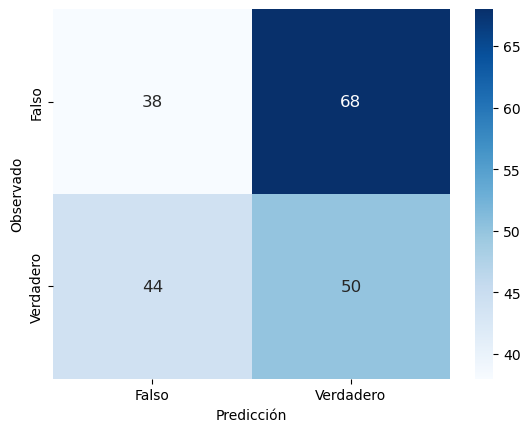

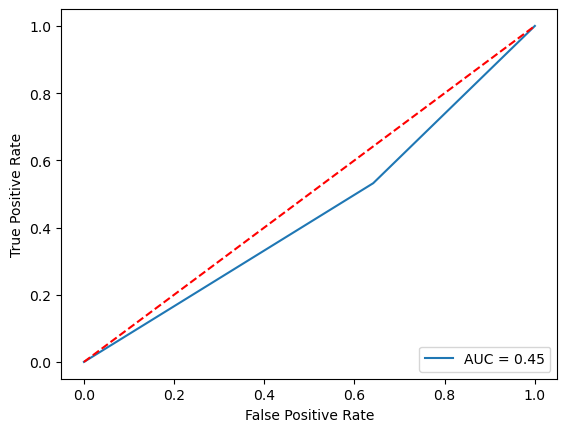

,model,accuracy,auc,ecm
0,LogisticRegression(),0.44,0.445203,0.56


In [29]:
# Le agregué una opción para visualizar la matriz de confusión, por si sirve.
evalua_metodo(LogisticRegression(), X_train, y_train, X_test, y_test, showmc=True, showroc=True)

2. Creamos la función `cross_validation()` la cual nos permitirá hacer la validación cruzada con *k* iteraciones.

In [30]:
def cross_validation(model, k, X, y):
    '''
    El objetivo de esta función es realizar un k-fold cross validation para evaluar el desempeño de un modelo de clasificación binaria.
    La función parte el dataset en K particiones de entrenamiento y test, y aplica la función evalua_metodo para cada una de las particiones.
    
    Argumentos:
    - modelo: El modelo de clasificación a evaluar.
    - k: parámetro para cross validation.
    - X: conjunto de datos de características.
    - y: La variable objetivo. 
    
    La función retorna un df que contiene el número de iteraciones (k), precisión y ECM promedio.
    
    '''
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    results = []
    
    for i, (train_index, test_index) in enumerate(kf.split(X), 1):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        model_metrics = evalua_metodo(model, X_train, y_train, X_test, y_test)
        model_metrics['k'] = i
        results.append(model_metrics)
    
    combined_results = pd.concat(results, ignore_index=True)
    
    # Calculamos la ECM promedio
    mean_accuracy = combined_results['accuracy'].mean()
    mean_ecm = combined_results['ecm'].mean()
    mean_auc=combined_results['auc'].mean()
    
    return pd.DataFrame({'model': [model], 'k': [k], 'accuracy_mean': [mean_accuracy], 'ecm_mean': [mean_ecm], 'auc_mean': [mean_auc]})

Probemos que la función `cross_validation()` funcione correctamente.

In [31]:
cross_validation(LogisticRegression(max_iter=10000), 5, X, y)

,model,k,accuracy_mean,ecm_mean,auc_mean
0,LogisticRegression(max_iter=10000),5,0.439,0.561,0.444563


3. Creamos la función `evalua_config()` que recibirá distintas combinaciones de hiperparámetros. Utilizamos la función `cross_validation()` previamente creada para cada configuración. La función devuelve la configuración que genera el menor ECM.

In [32]:
def evalua_config(configs, X, y, k):
    """
    El objetivo es evaluar distintas configuraciones de hiperparámetros 
    que definen a un modelo y devolver la mejor configuración con menor ECM.
    
    Argumentos:
    - configs (list): las distintas configuraciones a evaluar.
    - X: predictores
    - y: variables dependiente
    - k: parámetro para cross validation.
    
    El output es un diccionario con la mejor configuración y el menor ECM.
    """
    
    best_config = None
    menor_ecm = np.inf
    
    for config in configs:
        modelo = LogisticRegression(max_iter=10000, **config)
        resultados = cross_validation(modelo, k, X, y)
        ecm_promedio = resultados["ecm_mean"].mean() # El ECM promedio de las k iteraciones

    # Actualizamos la mejor configuración y el menor ECM:
        if ecm_promedio < menor_ecm:
            menor_ecm=ecm_promedio
            best_config=config 
    
    return {
        'Mejor configuración': best_config,
        'ECM menor': menor_ecm 
    }
    

Probamos que la función `evalua_config` esté funcionando correctamente. Creamos algunas configuraciones para que nos dé cuál es la mejor.

In [33]:
configlist = [
     {'penalty': 'l1', 'C': 0.5, 'solver': 'saga'},
     {'penalty': 'l1', 'C': 1, 'solver': 'saga'},  
     {'penalty': 'l2', 'C': 0.5},
     {'penalty': 'l2', 'C': 1}  
    ]

resultado = evalua_config(configlist, X, y,10)
print(resultado)

{'Mejor configuración': {'penalty': 'l1', 'C': 1, 'solver': 'saga'}, 'ECM menor': 0.527}


4. Escriban una función llamada `evalua_multiples_métodos` que les permita implementar los siguiente métodos con los hiperparámetros que ustedes elijan.

In [34]:
def evalua_multiples_metodos(configs_log, X, y, k, vecinos, componentes):
    
    """
    El objetivo es implementar distintos metodos con los hiperparametros a eleccion y  
    obtener metricas que permitan evaluarlos.
    
    Argumentos:
    - configs_log (list): las distintas configuraciones a evaluar para la regresion logistica.
    - X: predictores
    - y: variables dependiente
    - k: parámetro para cross validation.
    - vecinos (list): distintos numeros de vecinos a evaluar para el metodo de Vecinos Cercanos
    - componentes: numero de componentes para el Analisis Discriminante Lineal
    
    El output es un data frame que contiene el modelo, el valor de los hiperparametros, el ECM, el accuracy, y el AUC para cada modelo.
    """
    
    
    result= pd.DataFrame(columns=["modelo", "penalty", "C", "vecinos", "componentes", "ecm", "accuracy", "auc"])
    
    #Regresion logistica:
    mejor_conf= evalua_config(configs_log, X, y, k)
    mejor_conf= mejor_conf["Mejor configuración"]
    best_logistic_model=LogisticRegression(max_iter=10000, **mejor_conf) 
    metrics= cross_validation(best_logistic_model, k, X, y)
    result = result.append({"modelo": "Logit", "penalty": mejor_conf["penalty"], "C": mejor_conf["C"], "ecm": metrics.loc[metrics.index[0], "ecm_mean"], "accuracy": metrics.loc[metrics.index[0], "accuracy_mean"], "auc": metrics.loc[metrics.index[0], "auc_mean"]}, ignore_index=True) 
    
    #KNN:
    for v in vecinos:
        knn = KNeighborsClassifier(n_neighbors=v)
        metrics=cross_validation(knn, k, X, y)
        result = result.append({"modelo": "KNN", "vecinos": v, "ecm": metrics.loc[metrics.index[0], "ecm_mean"], "accuracy": metrics.loc[metrics.index[0], "accuracy_mean"], "auc": metrics.loc[metrics.index[0], "auc_mean"]}, ignore_index=True) 

   #LDA:
    lda=LinearDiscriminantAnalysis(n_components=componentes)
    metrics=cross_validation(lda, k, X, y)
    result = result.append({"modelo": "LDA", "componentes": componentes, "ecm": metrics.loc[metrics.index[0], "ecm_mean"], "accuracy": metrics.loc[metrics.index[0], "accuracy_mean"], "auc": metrics.loc[metrics.index[0], "auc_mean"]}, ignore_index=True) 

    return result    

In [35]:
#Probamos que evalua_multiples_metodos funcione:

configlist = [
    {'penalty': 'l1', 'C': 0.5, 'solver': 'saga'},
    {'penalty': 'l1', 'C': 1, 'solver': 'saga'},
    {'penalty': 'l2', 'C': 0.5},
    {'penalty': 'l2', 'C': 1} 
    ]

vecinos_prueba= [1, 5, 10]

evalua_multiples_metodos(configlist, X, y, 5, vecinos_prueba, 1)


C:\Users\Ronny\AppData\Local\Temp\ipykernel_2188\793200372.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result = result.append({"modelo": "Logit", "penalty": mejor_conf["penalty"], "C": mejor_conf["C"], "ecm": metrics.loc[metrics.index[0], "ecm_mean"], "accuracy": metrics.loc[metrics.index[0], "accuracy_mean"], "auc": metrics.loc[metrics.index[0], "auc_mean"]}, ignore_index=True)
C:\Users\Ronny\AppData\Local\Temp\ipykernel_2188\793200372.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result = result.append({"modelo": "KNN", "vecinos": v, "ecm": metrics.loc[metrics.index[0], "ecm_mean"], "accuracy": metrics.loc[metrics.index[0], "accuracy_mean"], "auc": metrics.loc[metrics.index[0], "auc_mean"]}, ignore_index=True)
C:\Users\Ronny\AppData\Local\Temp\ipykernel_2188\793200372.py:32: FutureWarning: The

,modelo,penalty,C,vecinos,componentes,ecm,accuracy,auc
0,Logit,l1,0.5,NaN,NaN,0.533,0.467,0.477723
1,KNN,NaN,NaN,1,NaN,0.509,0.491,0.491668
2,KNN,NaN,NaN,5,NaN,0.471,0.529,0.529670
3,KNN,NaN,NaN,10,NaN,0.474,0.526,0.527234
4,LDA,NaN,NaN,NaN,1,0.562,0.438,0.443201


## Parte III: Clasificación y regularización

El objetivo de esta parte del trabajo es nuevamente intentar predecir si una persona es o no pobre utilizando datos distintos al ingreso, dado que muchos hogares son reacios a responder cuánto ganan. Esta vez lo haremos con la base unida de las preguntas de la encuesta individual y la encuesta de hogar.  su vez, incluiremos ejercicios de regularización y de validación cruzada.

1. Eliminamos de las bases `respondieron` y `norespondieron` las variables relacionadas a ingresos y las variables creadas en base al método de adulto equivalente. Creamos la variable dependiente (pobre) y la matriz de variables independientes. En la parte I, como parte de la limpieza de datos, ya eliminamos casi todas estas variables, salvo ITF

In [36]:
#Eliminamos ITF de ambas bases, y tambien las variables CODUSU, NRO_HOGAR Y PONDIH, que no son utiles para la prediccion.
#Tambien eliminamos las variables "adulto_equiv", "ad_equiv_hogar" y "ingreso_necesario"
respondieron=respondieron.drop(columns=["ITF", "CODUSU", "NRO_HOGAR", "PONDIH", "adulto_equiv", "ad_equiv_hogar", "ingreso_necesario"])
norespondieron=norespondieron.drop(columns=["ITF", "CODUSU", "NRO_HOGAR", "adulto_equiv", "ad_equiv_hogar", "PONDIH"])


In [37]:
# Variable dependiente: pobre
y = respondieron["pobre"]
y=y.to_numpy()

In [38]:
#Matriz de variables independientes:
X = respondieron.drop(columns=["pobre"])
X= sm.add_constant(X) 


2. Corremos la función evalua_multiples_metodos con la base respondieron:

In [39]:
configlist = [
    {'penalty': 'l2', 'C': 0.1},
    {'penalty': 'l2', 'C': 100}, 
    {'penalty': 'l1', 'C': 0.1, 'solver': 'saga'},
    {'penalty': 'l1', 'C': 100, 'solver': 'saga' }
    ]

vecinos_prueba= [3, 5]

evalua_multiples_metodos(configlist, X, y, 5, vecinos_prueba, 1)

C:\Users\Ronny\AppData\Local\Temp\ipykernel_2188\793200372.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result = result.append({"modelo": "Logit", "penalty": mejor_conf["penalty"], "C": mejor_conf["C"], "ecm": metrics.loc[metrics.index[0], "ecm_mean"], "accuracy": metrics.loc[metrics.index[0], "accuracy_mean"], "auc": metrics.loc[metrics.index[0], "auc_mean"]}, ignore_index=True)


AttributeError: 'NoneType' object has no attribute 'split'

In [40]:
lambda_values = [10.0**n for n in np.arange(-1, 1)]
lambda_values

# Diccionarios vacíos
configlist_lasso = []
configlist_ridge = []

# Creamos el diccionario para cada valor de lambda (Lasso)
for lambda_val in lambda_values:
    C_val = 1 / lambda_val

    config_lasso = {'penalty': 'l1', 'C': C_val, 'solver': 'saga'} #l1 = Lasso
    configlist_lasso.append(config_lasso)

    config_ridge = {'penalty': 'l2', 'C': C_val} #l2 = Ridge
    configlist_ridge.append(config_ridge)


# Diccionario con todas las configuraciones dado el valor de lambda
configlist = configlist_lasso + configlist_ridge
configlist

[{'penalty': 'l1', 'C': 10.0, 'solver': 'saga'},
 {'penalty': 'l1', 'C': 1.0, 'solver': 'saga'},
 {'penalty': 'l2', 'C': 10.0},
 {'penalty': 'l2', 'C': 1.0}]

In [41]:
config_opt_lasso = evalua_config(configlist_lasso, X, y,5)
config_opt_lasso


KeyboardInterrupt: 

In [42]:
config_opt_ridge = evalua_config(configlist_ridge, X, y,5)
config_opt_ridge

{'Mejor configuración': {'penalty': 'l2', 'C': 10.0},
 'ECM menor': 0.27326494058854267}